# IRC belief to neural data 

Using IRC, we infered monkey's belief from their behavior.
We can then fit the neural acitivty to the behavioral inferred belief, to see the benifit of using IRC.


In [1]:
# imports
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir=Path(config['Datafolder']['data'])
workdir=Path(config['Codefolder']['workspace'])


In [9]:
sys.path.append(os.path.abspath(workdir))
sys.path.append(os.path.abspath(workdir/'test'))
# os.chdir(workdir/'test/neural')
os.chdir(workdir)


In [ ]:

from sklearn.model_selection import cross_val_predict, cross_val_score
import numpy as np
import torch
from sklearn.cross_decomposition import CCA
from numpy import pi
from matplotlib import pyplot as plt
from firefly_utils.data_handler import data_handler
from firefly_utils.spike_times_class import spike_counts
from firefly_utils.behav_class import *
from firefly_utils.lfp_class import lfp_class
from copy import deepcopy
from datetime import datetime
from scipy.interpolate import interp1d
from scipy.io import loadmat
import pickle
import pandas as pd
from numpy.lib.npyio import save
from cmaes import CMA
import copy
import matplotlib.pyplot as plt
import warnings
import heapq
from torch.distributions.multivariate_normal import MultivariateNormal
import time
from stable_baselines3 import TD3
from InverseFuncs import *
from monkey_functions import *
from firefly_task import ffacc_real
from env_config import Config
from notification import notify
from pathlib import Path
from sklearn import linear_model
from plot_ult import *
from sklearn.metrics import mean_squared_error, r2_score
import random
import scipy.interpolate as interpolate
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV


## Load neural data (.mat file) and behaviral data (from IRC)
the neural data file also has some behaivral data, such as current velocity.
we can use this as a sanity check to making sure things are right.

In [3]:
# load neural data

dat = loadmat(resdir/'neuraltest/m53s31.mat') # this is a example session with good recording, more neurons
# dat = loadmat(resdir/'neural/m53s36.mat') # this is a pert example


behav_stat_key = 'behv_stats'
spike_key = 'units'
behav_dat_key = 'trials_behv'
lfp_key = 'lfps'

pre_trial_dur = 0.5
post_trial_dur = 0.5
exp_data = data_handler(dat, behav_dat_key, spike_key, lfp_key, 
                        behav_stat_key, pre_trial_dur=pre_trial_dur,             extract_fly_and_monkey_xy=True,
                        post_trial_dur=post_trial_dur,extract_cartesian_eye_and_firefly=True,
                        lfp_beta=None, lfp_alpha=None, extract_lfp_phase=True)
# list(exp_data.behav.continuous.__dict__.keys())
exp_data.set_filters('all', True)
ts = exp_data.rebin_time_stamps(0.1)
t_targ=dict_to_vec(exp_data.behav.events.t_targ)
t_start=t_targ
t_stop = dict_to_vec(exp_data.behav.events.t_stop)
var_names = 'rad_vel','ang_vel','x_monk','y_monk', 'eye_hori', 'eye_vert','x_fly_screen','z_fly_screen','x_eye_screen','z_eye_screen',"x_fly_rel","y_fly_rel","ang_vel"
y,X,trial_idx = exp_data.concatenate_inputs(*var_names,t_start=t_start,t_stop=t_stop, time_stamps=ts)

trials=np.unique(trial_idx)
yes=0
total=0
for itrial in range(len(trials)):
    if len(X['x_fly_rel'][trial_idx==trials[itrial]])<1:
        continue
    d=(X['x_fly_rel'][trial_idx==trials[itrial]][-1]**2 + X['y_fly_rel'][trial_idx==trials[itrial]][-1]**2)**0.5
    if d < 65: yes+=1
    total+=1
print(f'number of trial: {len(trials)}, \nsession success rate is ', yes/total)


brainarea=dat['units']['brain_area']

unable to extract pairs, different blocks number
no eyetracking...
no normalized t_ptb (t_ptbn)
['all', 'reward', 'density', 'ptb', 'microstim', 'landmark', 'replay', 'controlgain', 'firefly_fullON']
Succesfully set filter
number of trial: 700, 
session success rate is  0.5642857142857143


In [4]:
# load behavioral data

with open(resdir/'neuraltest/res/m53s31_0223newformatbelief', 'rb') as f:
    res = pickle.load(f)

y_ = res['y']
X = {k: res[k] for k in ['rad_vel', 'ang_vel', 'x_monk', 'y_monk']}
trial_idx = res['trial_idx']
beliefs = res['belief']
covs = res['covs']
s = np.vstack([v for v in X.values()])
s = s.T


In [5]:
# use b-spline to process neural data

kernel_len = 7  # should be about +- 325ms
knots = np.hstack(([-1.001]*3, np.linspace(-1.001, 1.001, 5), [1.001]*3))
tp = np.linspace(-1., 1., kernel_len)
bX = splineDesign(knots, tp, ord=4, der=0, outer_ok=False)

# with initiate_plot(3, 2, 200) as f:
#     ax = f.add_subplot(111)
#     plt.plot(bX)
#     plt.title('B-spline kernel')
#     quickspine(ax)
#     plt.xticks([0, kernel_len-1])
#     ax.set_xticklabels([-kernel_len*50, kernel_len*50])
#     plt.xlabel('time, ms')
#     plt.ylabel('coef')


with suppress():
    modelX = convolve_loop(y_.T, trial_idx, bX)  # ts, neurons
pos_xy = np.hstack((X['x_monk'].reshape(-1, 1),
                   X['y_monk'].reshape(-1, 1)))  # ts, xy
# remove bad data
non_nan = ~np.isnan(pos_xy.sum(axis=1))
modelX = modelX[non_nan]
pos_xy = pos_xy[non_nan]
belief_xy = beliefs[:, [0, 1]][non_nan]

In [6]:
# calculate relative beliefs and states

states_rel, belief_rel = [], []
for itrial in range(len(trials)):
    xr, yr = world2mk(X['x_monk'][trial_idx == trials[itrial]], X['y_monk'][trial_idx == trials[itrial]], X['ang_vel'][trial_idx ==
                      trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    states_rel.append(np.vstack([xr, yr]))

    xr, yr = world2mk(beliefs[trial_idx == trials[itrial]][:, 0], beliefs[trial_idx == trials[itrial]][:, 1], X['ang_vel']
                      [trial_idx == trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    belief_rel.append(np.vstack([xr, yr]))

states_rel = np.hstack(states_rel).T
belief_rel = np.hstack(belief_rel).T

In [7]:
# calculate the relative cov (rotate ccw 180+heading from mid degree)

belief_heading = beliefs[:,2][non_nan]
rotdegree=belief_heading+180
relativeposcov=[]
for degree, thiscov in zip(rotdegree, covs):
    R=np.array([[np.cos(-degree/180*pi),-np.sin(-degree/180*pi)],[np.sin(-degree/180*pi),np.cos(-degree/180*pi)]])
    relativeposcov.append(R.T@thiscov[:2,:2]@R)
relativeposcov=np.stack(relativeposcov)
relativeposcov.shape


(11331, 2, 2)

In [10]:
# uncertainty var and std from cov.

uncertainty_var=[c[:2,:2].flatten()[[0,3]] for c in relativeposcov]
uncertainty_var=np.array(uncertainty_var)
uncertainty_std=np.power(uncertainty_var, 0.5)[:,]



In [ ]:
# time

trialtime=[]
fulltime=np.arange(0,7,0.1)
for itrial in range(len(trials)):
    thistime=len(X['x_monk'][trial_idx==trials[itrial]])
    trialtime.append(fulltime[:thistime])
trialtime=np.hstack(trialtime).T

trialtime=trialtime.reshape(-1,1)

In [31]:
np.stack([thisv,thisw])

array([[9.95149671e-03, 9.74409736e+00, 8.25168178e+01, 2.42969313e+02,
        4.34484272e+02, 6.25965229e+02, 8.17456272e+02, 1.00895061e+03,
        1.18639951e+03, 1.28396167e+03],
       [1.78444720e-02, 6.44909855e-03, 1.18163946e+01, 3.78190085e+01,
        6.99197826e+01, 1.02403222e+02, 1.34845966e+02, 1.66966719e+02,
        1.89516806e+02, 1.81750136e+02]])

In [33]:
# cumulative distance traveled and angle turned

pathtraveled=[]
for itrial in range(len(trials)):
    thisv=np.cumsum(X['rad_vel'][trial_idx==trials[itrial]])
    thisw=np.cumsum(X['ang_vel'][trial_idx==trials[itrial]])
    pathtraveled.append(np.stack([thisv,thisw]))
pathtraveled=np.hstack(pathtraveled).T

(11331, 2)

In [35]:
def quantilenormalize(together, scale=100):
    return (together-np.quantile(together, 0.05, axis=0))/(np.quantile(together, 0.95, axis=0)-np.quantile(together, 0.05, axis=0))*scale

# Fitting

## remove the un wantted feature by lasso

In [36]:
# select features to use

# together=np.hstack([uncertainty_var,uncertainty_std])
# together_normalized=quantilenormalize(together)
together=pathtraveled
x,y=modelX,quantilenormalize(pathtraveled)


# Create a parameter grid with alpha values
param_grid = {'alpha': [ 0.1, 1.0]}

# Initialize the Lasso model
model = linear_model.Lasso()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(x, y)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

print("Best alpha value:", best_alpha)



Best alpha value: 0.1


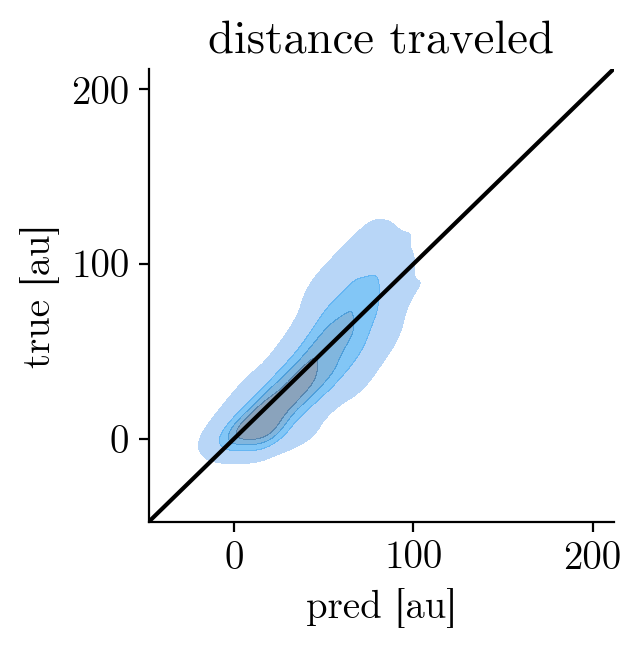

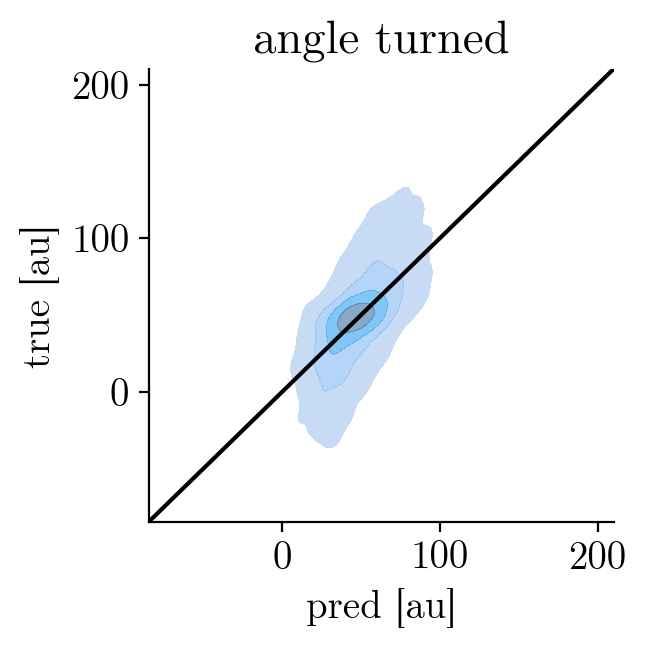

<AxesSubplot:title={'center':'angle turned'}, xlabel='pred [au]', ylabel='true [au]'>

In [44]:
x,y=modelX,quantilenormalize(pathtraveled)

model = linear_model.Lasso(alpha=best_alpha)
model.fit(x,y)

pred=model.predict(x)
plot_pred(pred[:,0],y[:,0], title='distance traveled', unit='au',every=1)
plot_pred(pred[:,1],y[:,1], title='angle turned', unit='au',every=1)



## remove the most important features

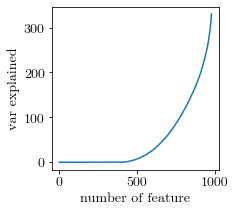

In [49]:
plt.plot(np.cumsum(sorted(abs(np.sum(model.coef_, axis=0)))))
plt.xlabel('number of feature')
plt.ylabel('var explained')

selectedfeature=np.argsort(abs(np.sum(model.coef_, axis=0)))[:400]
x=modelX[:,selectedfeature]


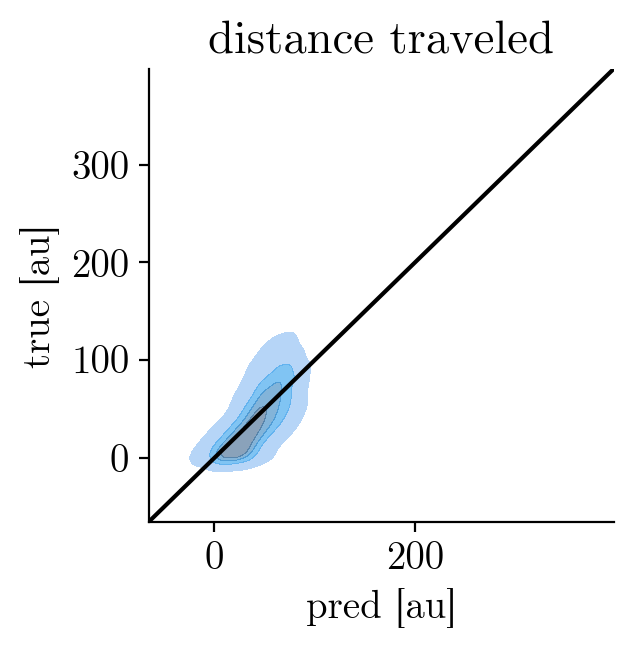

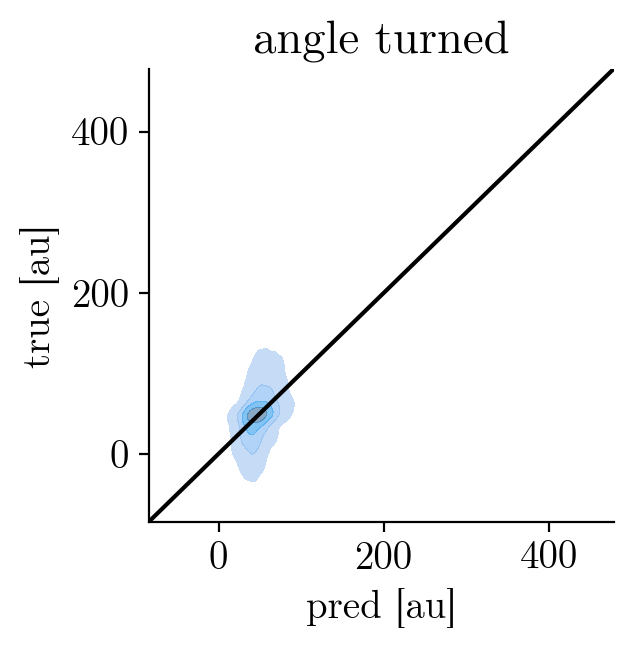

<AxesSubplot:title={'center':'angle turned'}, xlabel='pred [au]', ylabel='true [au]'>

In [51]:
# model = linear_model.Lasso(alpha=best_alpha)
# model.fit(x,y)
# pred=model.predict(x)

model = linear_model.RidgeCV(alphas=[0.1, 1.0], cv=5)  # 5-fold cross-validation
# Using cross_val_predict to make predictions
pred = cross_val_predict(model, x, y, cv=5)  

plot_pred(pred[:,0],y[:,0], title='distance traveled', unit='au',every=1)
plot_pred(pred[:,1],y[:,1], title='angle turned', unit='au',every=1)

## augmented xy, whitening

In [57]:
modelX.shape, (quantilenormalize(pathtraveled)).shape

((11331, 980), (11331, 2))

In [106]:
# augment
together=np.hstack([modelX, quantilenormalize(pathtraveled)])
together=(together)

# whitening
from scipy.linalg import sqrtm

# Step 3: Compute the covariance matrix
covariance_matrix = np.cov(together-np.mean(together, axis=1).reshape(-1,1))
eps=np.diag([1e-7]*len(covariance_matrix))
covariance_matrix+=eps

# Step 4: Eigenvalue decomposition



In [107]:
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
# Step 5: Whiten the data
whitened_data = np.dot(sqrtm(np.linalg.inv(np.diag(eigenvalues))), eigenvectors.T).dot(together)
eigenvalues

array([9.99862061e-08, 9.99949450e-08, 9.99969130e-08, ...,
       1.06118187e+03, 9.44168442e+03, 6.13056727e+04])

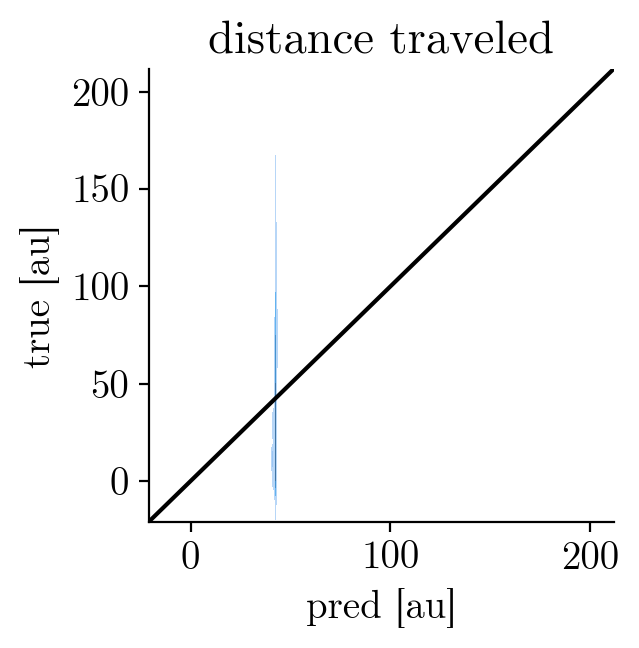

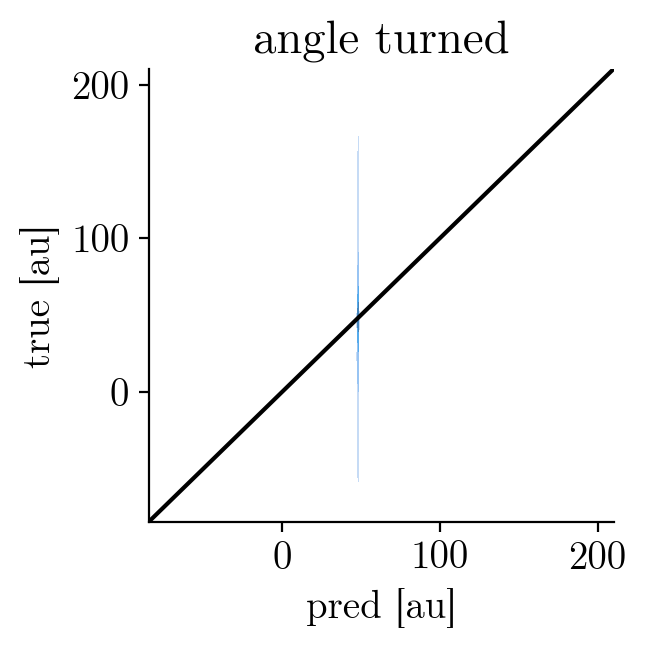

<AxesSubplot:title={'center':'angle turned'}, xlabel='pred [au]', ylabel='true [au]'>

In [108]:
x=whitened_data[:,:-2]
y=quantilenormalize(pathtraveled)

model = linear_model.Lasso(alpha=best_alpha)
model.fit(x,y)

pred=model.predict(x)
plot_pred(pred[:,0],y[:,0], title='distance traveled', unit='au',every=1)
plot_pred(pred[:,1],y[:,1], title='angle turned', unit='au',every=1)

In [109]:
x=whitened_data[:,:-2]

together=np.hstack([uncertainty_var,uncertainty_std])
together_normalized=quantilenormalize(together)

y=together_normalized


# Create a parameter grid with alpha values
param_grid = {'alpha': [ 0.1, 1.0]}

# Initialize the Lasso model
model = linear_model.Lasso()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(x, y)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

print("Best alpha value:", best_alpha)


Best alpha value: 1.0


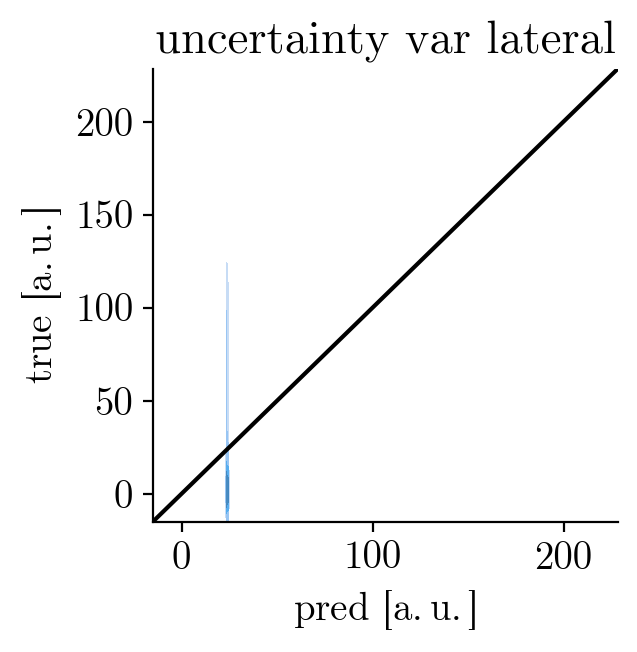

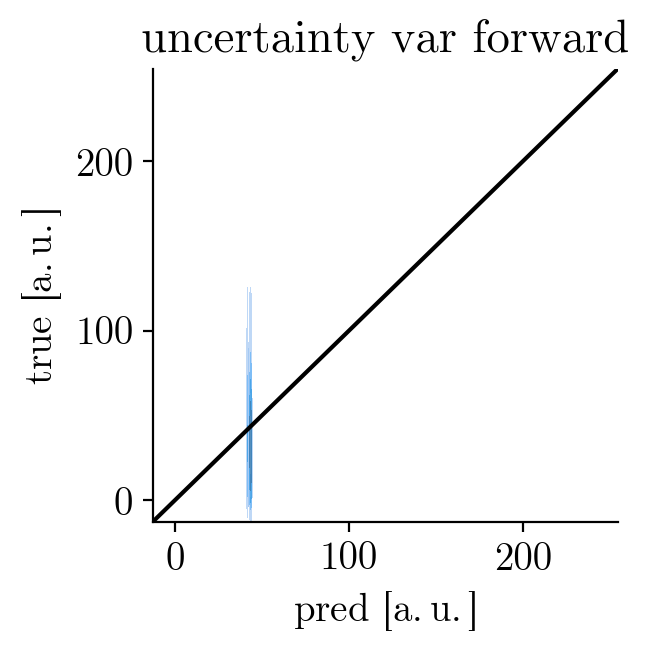

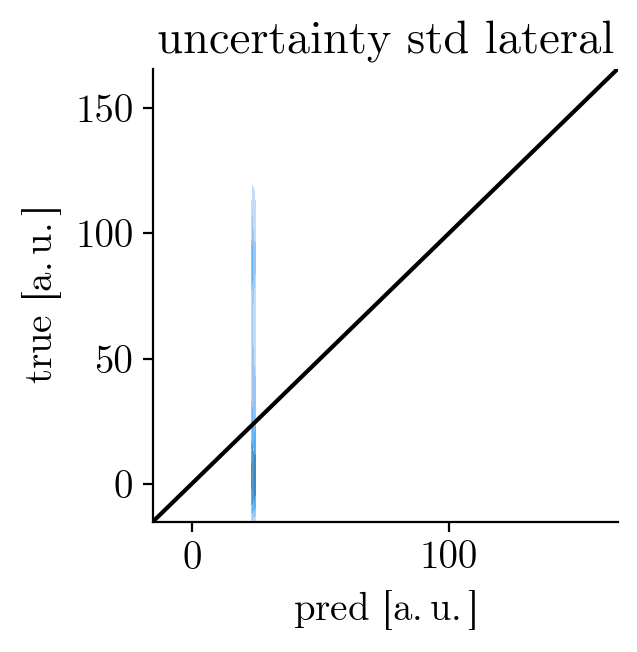

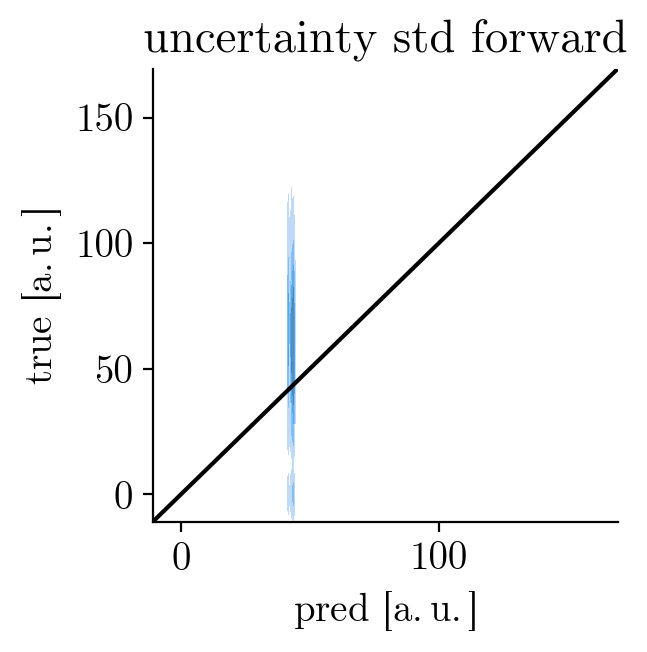

<AxesSubplot:title={'center':'uncertainty std forward'}, xlabel='pred [$a.u.$]', ylabel='true [$a.u.$]'>

In [110]:
pred = cross_val_predict(model, x, y, cv=5)  # 5-fold cross-validation


plot_pred(pred[:,0],y[:,0], title='uncertainty var lateral', unit=r'$a.u.$',every=1)
plot_pred(pred[:,1],y[:,1], title='uncertainty var forward', unit=r'$a.u.$',every=1)
plot_pred(pred[:,0],y[:,2], title='uncertainty std lateral', unit=r'$a.u.$',every=1)
plot_pred(pred[:,1],y[:,3], title='uncertainty std forward', unit=r'$a.u.$',every=1) 